In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data("../input/train_test_extb.npy.npz")
len(columns),data.shape

(1, 829, 517) (60, 829, 517)


(68, (829, 517, 68))

In [5]:
gc.collect()

15

In [6]:
0.232098116004**.5

0.4817656235183245

In [7]:
#show_data(data,columns, 1,480, None)

In [8]:
#show_data2(data,columns)

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [11]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'station_count_y3', 'station_count_y4'])
lag_cols=columns
len(lag_cols)

68

In [13]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG'])

In [15]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool
from sklearn.linear_model import Ridge

# time split

In [17]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [18]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [19]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
       
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        trainpred=gbm.predict(trainX)
        scores.append(mean_squared_error(validy,validpred))
        print 'train/valid score', mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred,trainpred
        #return np.mean(scores) 

In [20]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [21]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def h(model,train_gen):
    Xdict,y,dataidx,_=train_gen.get_by_t2(day=478)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0
    y=np.squeeze(y)
    print X.shape,y.shape
    pred=model.predict(X)
    return y,dataidx,pred,X



In [22]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [23]:
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,exclude_hard=True)
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    valid_gen=test_gen
    valid_gen=None
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,trainidx=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)
    
    trainX=np.concatenate([trainX,validX])
    trainy=np.concatenate([trainy,validy])
    trainidx=np.concatenate([trainidx,valididx])
    
    model,score,validpred,trainpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),(trainy,trainidx,trainpred),pred478

def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [24]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [25]:
1-0.22/np.nanvar(rawy)

0.66279294265542088

In [26]:
reload(rrvf_data)
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,trainpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]




1
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (178505, 2) (19669, 2)
rand split across time
train has 178505 records out of 389630 records
valid has 19669 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1394
0
(178505, 1, 6) (178505, 7, 68) (178505, 1) (178505, 1)
(178505, 482) (178505,) (178505,)
(19669, 1, 6) (19669, 7, 68) (19669, 1) (19669, 1)
(19669, 482) (19669,) (19669,)
(5803, 1, 6) (5803, 7, 68) (5803, 1) (5803, 1)
(5803, 482) (5803,) (5803,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.20838752472e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.0927138 0.0896154
[0.089615412]
-1 mean score 0.0896154
0.249486


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.991297 -0.062187  0.281438    7  2017-04-16
472     2.507290  2.607327 -0.100037  0.280224    1  2017-04-17
473     2.661330  2.674319 -0.012989  0.292521    2  2017-04-18
474     2.754815  2.780292 -0.025477  0.241428    3  2017-04-19
475     2.713762  2.772236 -0.058474  0.267635    4  2017-04-20
476     2.999000  2.980111  0.018889  0.173482    5  2017-04-21
477     3.075529  3.125648 -0.050118  0.209675    6  2017-04-22

0.249486


pred         y     error    error2  day        date
dayidx                                                         
471     2.991297  2.929110 -0.062187  0.281438    7  2017-04-16
472     2.607327  2.507290 -0.100037  0.280224    1  2017-04-17
473     2.674319  2.661330 -0.012989  0.292521    2  2017-04-18
474     2.780292  2.754815 -0.025477  0.241428    3  2017-04-19
475     2.772236  2.713762 -0.058474  0.267635    4  2017-04-20
476     2.980111  2.999000  0.018889  0.173482    5  2017-04-21
477     3.125648  3.075529 -0.050118  0.209675    6  2017-04-22

(829, 964) (829,)


2
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (184564, 2) (20245, 2)
rand split across time
train has 184564 records out of 389630 records
valid has 20245 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1441
0
(184564, 1, 6) (184564, 7, 68) (184564, 1) (184564, 1)
(184564, 482) (184564,) (184564,)
(20245, 1, 6) (20245, 7, 68) (20245, 1) (20245, 1)
(20245, 482) (20245,) (20245,)
(6632, 1, 6) (6632, 7, 68) (6632, 1) (6632, 1)
(6632, 482) (6632,) (6632,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.90899212841e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.0957204 0.0920241
[0.09202411]
-1 mean score 0.0920241
0.248272


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.956067 -0.026957  0.278067    7  2017-04-16
472     2.507290  2.606902 -0.099612  0.277695    1  2017-04-17
473     2.661330  2.692845 -0.031515  0.290199    2  2017-04-18
474     2.754815  2.795579 -0.040764  0.244519    3  2017-04-19
475     2.713762  2.785269 -0.071508  0.268349    4  2017-04-20
476     2.999000  2.998548  0.000452  0.174717    5  2017-04-21
477     3.075529  3.083854 -0.008325  0.204358    6  2017-04-22

0.248272


pred         y     error    error2  day        date
dayidx                                                         
471     2.956067  2.929110 -0.026957  0.278067    7  2017-04-16
472     2.606902  2.507290 -0.099612  0.277695    1  2017-04-17
473     2.692845  2.661330 -0.031515  0.290199    2  2017-04-18
474     2.795579  2.754815 -0.040764  0.244519    3  2017-04-19
475     2.785269  2.713762 -0.071508  0.268349    4  2017-04-20
476     2.998548  2.999000  0.000452  0.174717    5  2017-04-21
477     3.083854  3.075529 -0.008325  0.204358    6  2017-04-22

(829, 964) (829,)


3
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185140, 2) (20251, 2)
rand split across time
train has 185140 records out of 389630 records
valid has 20251 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1446
0
(185140, 1, 6) (185140, 7, 68) (185140, 1) (185140, 1)
(185140, 482) (185140,) (185140,)
(20251, 1, 6) (20251, 7, 68) (20251, 1) (20251, 1)
(20251, 482) (20251,) (20251,)
(7461, 1, 6) (7461, 7, 68) (7461, 1) (7461, 1)
(7461, 482) (7461,) (7461,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.53824502819e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.0977293 0.0944624
[0.094462432]
-1 mean score 0.0944624
0.248561


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.949826 -0.020716  0.275339    7  2017-04-16
472     2.507290  2.610851 -0.103560  0.277633    1  2017-04-17
473     2.661330  2.676210 -0.014880  0.291439    2  2017-04-18
474     2.754815  2.796335 -0.041520  0.243771    3  2017-04-19
475     2.713762  2.782848 -0.069087  0.271309    4  2017-04-20
476     2.999000  2.998668  0.000331  0.175332    5  2017-04-21
477     3.075529  3.098744 -0.023215  0.205104    6  2017-04-22

0.248561


pred         y     error    error2  day        date
dayidx                                                         
471     2.949826  2.929110 -0.020716  0.275339    7  2017-04-16
472     2.610851  2.507290 -0.103560  0.277633    1  2017-04-17
473     2.676210  2.661330 -0.014880  0.291439    2  2017-04-18
474     2.796335  2.754815 -0.041520  0.243771    3  2017-04-19
475     2.782848  2.713762 -0.069087  0.271309    4  2017-04-20
476     2.998668  2.999000  0.000331  0.175332    5  2017-04-21
477     3.098744  3.075529 -0.023215  0.205104    6  2017-04-22

(829, 964) (829,)


4
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185231, 2) (20285, 2)
rand split across time
train has 185231 records out of 389630 records
valid has 20285 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1447
0
(185231, 1, 6) (185231, 7, 68) (185231, 1) (185231, 1)
(185231, 482) (185231,) (185231,)
(20285, 1, 6) (20285, 7, 68) (20285, 1) (20285, 1)
(20285, 482) (20285,) (20285,)
(8290, 1, 6) (8290, 7, 68) (8290, 1) (8290, 1)
(8290, 482) (8290,) (8290,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.00582786228e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.0991423 0.0958544
[0.095854357]
-1 mean score 0.0958544
0.248437


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931965 -0.002855  0.274547    7  2017-04-16
472     2.507290  2.601677 -0.094387  0.273863    1  2017-04-17
473     2.661330  2.651026  0.010304  0.292904    2  2017-04-18
474     2.754815  2.780716 -0.025901  0.242474    3  2017-04-19
475     2.713762  2.776943 -0.063182  0.272218    4  2017-04-20
476     2.999000  2.965829  0.033171  0.178194    5  2017-04-21
477     3.075529  3.100829 -0.025300  0.204857    6  2017-04-22

0.248437


pred         y     error    error2  day        date
dayidx                                                         
471     2.931965  2.929110 -0.002855  0.274547    7  2017-04-16
472     2.601677  2.507290 -0.094387  0.273863    1  2017-04-17
473     2.651026  2.661330  0.010304  0.292904    2  2017-04-18
474     2.780716  2.754815 -0.025901  0.242474    3  2017-04-19
475     2.776943  2.713762 -0.063182  0.272218    4  2017-04-20
476     2.965829  2.999000  0.033171  0.178194    5  2017-04-21
477     3.100829  3.075529 -0.025300  0.204857    6  2017-04-22

(829, 964) (829,)


5
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185367, 2) (20346, 2)
rand split across time
train has 185367 records out of 389630 records
valid has 20346 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1448
0
(185367, 1, 6) (185367, 7, 68) (185367, 1) (185367, 1)
(185367, 482) (185367,) (185367,)
(20346, 1, 6) (20346, 7, 68) (20346, 1) (20346, 1)
(20346, 482) (20346,) (20346,)
(9119, 1, 6) (9119, 7, 68) (9119, 1) (9119, 1)
(9119, 482) (9119,) (9119,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.83428175163e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.100601 0.0970125
[0.097012505]
-1 mean score 0.0970125
0.247664


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.946578 -0.017468  0.274742    7  2017-04-16
472     2.507290  2.597891 -0.090601  0.271691    1  2017-04-17
473     2.661330  2.660179  0.001150  0.290344    2  2017-04-18
474     2.754815  2.752346  0.002468  0.242189    3  2017-04-19
475     2.713762  2.755910 -0.042148  0.269313    4  2017-04-20
476     2.999000  2.961315  0.037685  0.179062    5  2017-04-21
477     3.075529  3.074510  0.001020  0.206304    6  2017-04-22

0.247664


pred         y     error    error2  day        date
dayidx                                                         
471     2.946578  2.929110 -0.017468  0.274742    7  2017-04-16
472     2.597891  2.507290 -0.090601  0.271691    1  2017-04-17
473     2.660179  2.661330  0.001150  0.290344    2  2017-04-18
474     2.752346  2.754815  0.002468  0.242189    3  2017-04-19
475     2.755910  2.713762 -0.042148  0.269313    4  2017-04-20
476     2.961315  2.999000  0.037685  0.179062    5  2017-04-21
477     3.074510  3.075529  0.001020  0.206304    6  2017-04-22

(829, 964) (829,)


6
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185287, 2) (20351, 2)
rand split across time
train has 185287 records out of 389630 records
valid has 20351 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1447
0
(185287, 1, 6) (185287, 7, 68) (185287, 1) (185287, 1)
(185287, 482) (185287,) (185287,)
(20351, 1, 6) (20351, 7, 68) (20351, 1) (20351, 1)
(20351, 482) (20351,) (20351,)
(9948, 1, 6) (9948, 7, 68) (9948, 1) (9948, 1)
(9948, 482) (9948,) (9948,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.08816824679e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.10178 0.097428
[0.097428009]
-1 mean score 0.097428
0.247947


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943816 -0.014706  0.272651    7  2017-04-16
472     2.507290  2.603167 -0.095876  0.272992    1  2017-04-17
473     2.661330  2.657660  0.003669  0.291313    2  2017-04-18
474     2.754815  2.759797 -0.004982  0.240318    3  2017-04-19
475     2.713762  2.756215 -0.042454  0.270264    4  2017-04-20
476     2.999000  2.941752  0.057248  0.181284    5  2017-04-21
477     3.075529  3.087532 -0.012003  0.206810    6  2017-04-22

0.247947


pred         y     error    error2  day        date
dayidx                                                         
471     2.943816  2.929110 -0.014706  0.272651    7  2017-04-16
472     2.603167  2.507290 -0.095876  0.272992    1  2017-04-17
473     2.657660  2.661330  0.003669  0.291313    2  2017-04-18
474     2.759797  2.754815 -0.004982  0.240318    3  2017-04-19
475     2.756215  2.713762 -0.042454  0.270264    4  2017-04-20
476     2.941752  2.999000  0.057248  0.181284    5  2017-04-21
477     3.087532  3.075529 -0.012003  0.206810    6  2017-04-22

(829, 964) (829,)


7
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185718, 2) (20388, 2)
rand split across time
train has 185718 records out of 389630 records
valid has 20388 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1450
0
(185718, 1, 6) (185718, 7, 68) (185718, 1) (185718, 1)
(185718, 482) (185718,) (185718,)
(20388, 1, 6) (20388, 7, 68) (20388, 1) (20388, 1)
(20388, 482) (20388,) (20388,)
(10777, 1, 6) (10777, 7, 68) (10777, 1) (10777, 1)
(10777, 482) (10777,) (10777,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.17485029722e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.103553 0.0990741
[0.099074133]
-1 mean score 0.0990741
0.247478


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.941086 -0.011976  0.270764    7  2017-04-16
472     2.507290  2.616790 -0.109500  0.279630    1  2017-04-17
473     2.661330  2.672760 -0.011430  0.294496    2  2017-04-18
474     2.754815  2.749291  0.005524  0.242588    3  2017-04-19
475     2.713762  2.749694 -0.035932  0.266109    4  2017-04-20
476     2.999000  2.957331  0.041669  0.178101    5  2017-04-21
477     3.075529  3.096496 -0.020967  0.200656    6  2017-04-22

0.247478


pred         y     error    error2  day        date
dayidx                                                         
471     2.941086  2.929110 -0.011976  0.270764    7  2017-04-16
472     2.616790  2.507290 -0.109500  0.279630    1  2017-04-17
473     2.672760  2.661330 -0.011430  0.294496    2  2017-04-18
474     2.749291  2.754815  0.005524  0.242588    3  2017-04-19
475     2.749694  2.713762 -0.035932  0.266109    4  2017-04-20
476     2.957331  2.999000  0.041669  0.178101    5  2017-04-21
477     3.096496  3.075529 -0.020967  0.200656    6  2017-04-22

(829, 964) (829,)


8
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185000, 2) (20354, 2)
rand split across time
train has 185000 records out of 389630 records
valid has 20354 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1445
0
(185000, 1, 6) (185000, 7, 68) (185000, 1) (185000, 1)
(185000, 482) (185000,) (185000,)
(20354, 1, 6) (20354, 7, 68) (20354, 1) (20354, 1)
(20354, 482) (20354,) (20354,)
(11606, 1, 6) (11606, 7, 68) (11606, 1) (11606, 1)
(11606, 482) (11606,) (11606,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.05851713084e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.112115 0.106405
[0.10640488]
-1 mean score 0.106405
0.255893


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.966130 -0.037021  0.284030    7  2017-04-16
472     2.507290  2.620723 -0.113432  0.281412    1  2017-04-17
473     2.661330  2.698002 -0.036672  0.300850    2  2017-04-18
474     2.754815  2.770584 -0.015769  0.259364    3  2017-04-19
475     2.713762  2.750903 -0.037141  0.273575    4  2017-04-20
476     2.999000  2.989712  0.009287  0.185644    5  2017-04-21
477     3.075529  3.117996 -0.042466  0.206378    6  2017-04-22

0.255893


pred         y     error    error2  day        date
dayidx                                                         
471     2.966130  2.929110 -0.037021  0.284030    7  2017-04-16
472     2.620723  2.507290 -0.113432  0.281412    1  2017-04-17
473     2.698002  2.661330 -0.036672  0.300850    2  2017-04-18
474     2.770584  2.754815 -0.015769  0.259364    3  2017-04-19
475     2.750903  2.713762 -0.037141  0.273575    4  2017-04-20
476     2.989712  2.999000  0.009287  0.185644    5  2017-04-21
477     3.117996  3.075529 -0.042466  0.206378    6  2017-04-22

(829, 964) (829,)


9
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186155, 2) (20441, 2)
rand split across time
train has 186155 records out of 389630 records
valid has 20441 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1454
0
(186155, 1, 6) (186155, 7, 68) (186155, 1) (186155, 1)
(186155, 482) (186155,) (186155,)
(20441, 1, 6) (20441, 7, 68) (20441, 1) (20441, 1)
(20441, 482) (20441,) (20441,)
(12435, 1, 6) (12435, 7, 68) (12435, 1) (12435, 1)
(12435, 482) (12435,) (12435,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.36300109824e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.113498 0.107936
[0.10793576]
-1 mean score 0.107936
0.255702


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.962173 -0.033063  0.282690    7  2017-04-16
472     2.507290  2.624512 -0.117222  0.282488    1  2017-04-17
473     2.661330  2.708573 -0.047243  0.306374    2  2017-04-18
474     2.754815  2.773075 -0.018260  0.256621    3  2017-04-19
475     2.713762  2.758194 -0.044432  0.273642    4  2017-04-20
476     2.999000  2.980162  0.018838  0.185839    5  2017-04-21
477     3.075529  3.100937 -0.025408  0.202261    6  2017-04-22

0.255702


pred         y     error    error2  day        date
dayidx                                                         
471     2.962173  2.929110 -0.033063  0.282690    7  2017-04-16
472     2.624512  2.507290 -0.117222  0.282488    1  2017-04-17
473     2.708573  2.661330 -0.047243  0.306374    2  2017-04-18
474     2.773075  2.754815 -0.018260  0.256621    3  2017-04-19
475     2.758194  2.713762 -0.044432  0.273642    4  2017-04-20
476     2.980162  2.999000  0.018838  0.185839    5  2017-04-21
477     3.100937  3.075529 -0.025408  0.202261    6  2017-04-22

(829, 964) (829,)


10
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186354, 2) (20378, 2)
rand split across time
train has 186354 records out of 389630 records
valid has 20378 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1455
0
(186354, 1, 6) (186354, 7, 68) (186354, 1) (186354, 1)
(186354, 482) (186354,) (186354,)
(20378, 1, 6) (20378, 7, 68) (20378, 1) (20378, 1)
(20378, 482) (20378,) (20378,)
(13264, 1, 6) (13264, 7, 68) (13264, 1) (13264, 1)
(13264, 482) (13264,) (13264,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.06836046954e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.114187 0.109321
[0.10932096]
-1 mean score 0.109321
0.255896


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.965651 -0.036541  0.284664    7  2017-04-16
472     2.507290  2.626830 -0.119539  0.281009    1  2017-04-17
473     2.661330  2.702479 -0.041149  0.307530    2  2017-04-18
474     2.754815  2.763110 -0.008295  0.257666    3  2017-04-19
475     2.713762  2.760000 -0.046238  0.274994    4  2017-04-20
476     2.999000  2.993553  0.005447  0.183963    5  2017-04-21
477     3.075529  3.084467 -0.008938  0.201448    6  2017-04-22

0.255896


pred         y     error    error2  day        date
dayidx                                                         
471     2.965651  2.929110 -0.036541  0.284664    7  2017-04-16
472     2.626830  2.507290 -0.119539  0.281009    1  2017-04-17
473     2.702479  2.661330 -0.041149  0.307530    2  2017-04-18
474     2.763110  2.754815 -0.008295  0.257666    3  2017-04-19
475     2.760000  2.713762 -0.046238  0.274994    4  2017-04-20
476     2.993553  2.999000  0.005447  0.183963    5  2017-04-21
477     3.084467  3.075529 -0.008938  0.201448    6  2017-04-22

(829, 964) (829,)


11
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186285, 2) (20401, 2)
rand split across time
train has 186285 records out of 389630 records
valid has 20401 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1455
0
(186285, 1, 6) (186285, 7, 68) (186285, 1) (186285, 1)
(186285, 482) (186285,) (186285,)
(20401, 1, 6) (20401, 7, 68) (20401, 1) (20401, 1)
(20401, 482) (20401,) (20401,)
(14093, 1, 6) (14093, 7, 68) (14093, 1) (14093, 1)
(14093, 482) (14093,) (14093,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3123614695e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.114506 0.109762
[0.10976192]
-1 mean score 0.109762
0.255295


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.955917 -0.026807  0.284417    7  2017-04-16
472     2.507290  2.634780 -0.127490  0.284197    1  2017-04-17
473     2.661330  2.712325 -0.050995  0.306060    2  2017-04-18
474     2.754815  2.750778  0.004036  0.255172    3  2017-04-19
475     2.713762  2.750154 -0.036393  0.274100    4  2017-04-20
476     2.999000  2.997301  0.001699  0.180901    5  2017-04-21
477     3.075529  3.097876 -0.022347  0.202215    6  2017-04-22

0.255295


pred         y     error    error2  day        date
dayidx                                                         
471     2.955917  2.929110 -0.026807  0.284417    7  2017-04-16
472     2.634780  2.507290 -0.127490  0.284197    1  2017-04-17
473     2.712325  2.661330 -0.050995  0.306060    2  2017-04-18
474     2.750778  2.754815  0.004036  0.255172    3  2017-04-19
475     2.750154  2.713762 -0.036393  0.274100    4  2017-04-20
476     2.997301  2.999000  0.001699  0.180901    5  2017-04-21
477     3.097876  3.075529 -0.022347  0.202215    6  2017-04-22

(829, 964) (829,)


12
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186266, 2) (20441, 2)
rand split across time
train has 186266 records out of 389630 records
valid has 20441 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1455
0
(186266, 1, 6) (186266, 7, 68) (186266, 1) (186266, 1)
(186266, 482) (186266,) (186266,)
(20441, 1, 6) (20441, 7, 68) (20441, 1) (20441, 1)
(20441, 482) (20441,) (20441,)
(14922, 1, 6) (14922, 7, 68) (14922, 1) (14922, 1)
(14922, 482) (14922,) (14922,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.03588256029e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.114404 0.108352
[0.10835242]
-1 mean score 0.108352
0.256762


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.967766 -0.038656  0.284764    7  2017-04-16
472     2.507290  2.640753 -0.133462  0.285835    1  2017-04-17
473     2.661330  2.721695 -0.060365  0.306711    2  2017-04-18
474     2.754815  2.762774 -0.007959  0.258696    3  2017-04-19
475     2.713762  2.742444 -0.028683  0.274551    4  2017-04-20
476     2.999000  2.986512  0.012488  0.183697    5  2017-04-21
477     3.075529  3.103452 -0.027923  0.203078    6  2017-04-22

0.256762


pred         y     error    error2  day        date
dayidx                                                         
471     2.967766  2.929110 -0.038656  0.284764    7  2017-04-16
472     2.640753  2.507290 -0.133462  0.285835    1  2017-04-17
473     2.721695  2.661330 -0.060365  0.306711    2  2017-04-18
474     2.762774  2.754815 -0.007959  0.258696    3  2017-04-19
475     2.742444  2.713762 -0.028683  0.274551    4  2017-04-20
476     2.986512  2.999000  0.012488  0.183697    5  2017-04-21
477     3.103452  3.075529 -0.027923  0.203078    6  2017-04-22

(829, 964) (829,)


13
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186174, 2) (20456, 2)
rand split across time
train has 186174 records out of 389630 records
valid has 20456 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1454
0
(186174, 1, 6) (186174, 7, 68) (186174, 1) (186174, 1)
(186174, 482) (186174,) (186174,)
(20456, 1, 6) (20456, 7, 68) (20456, 1) (20456, 1)
(20456, 482) (20456,) (20456,)
(15751, 1, 6) (15751, 7, 68) (15751, 1) (15751, 1)
(15751, 482) (15751,) (15751,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.3447504195e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.114706 0.108672
[0.10867234]
-1 mean score 0.108672
0.257156


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.968075 -0.038965  0.288562    7  2017-04-16
472     2.507290  2.655355 -0.148065  0.288972    1  2017-04-17
473     2.661330  2.716104 -0.054774  0.306219    2  2017-04-18
474     2.754815  2.764228 -0.009414  0.256900    3  2017-04-19
475     2.713762  2.751090 -0.037328  0.274154    4  2017-04-20
476     2.999000  2.990778  0.008222  0.182284    5  2017-04-21
477     3.075529  3.089683 -0.014154  0.203003    6  2017-04-22

0.257156


pred         y     error    error2  day        date
dayidx                                                         
471     2.968075  2.929110 -0.038965  0.288562    7  2017-04-16
472     2.655355  2.507290 -0.148065  0.288972    1  2017-04-17
473     2.716104  2.661330 -0.054774  0.306219    2  2017-04-18
474     2.764228  2.754815 -0.009414  0.256900    3  2017-04-19
475     2.751090  2.713762 -0.037328  0.274154    4  2017-04-20
476     2.990778  2.999000  0.008222  0.182284    5  2017-04-21
477     3.089683  3.075529 -0.014154  0.203003    6  2017-04-22

(829, 964) (829,)


14
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186454, 2) (20485, 2)
rand split across time
train has 186454 records out of 389630 records
valid has 20485 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1456
0
(186454, 1, 6) (186454, 7, 68) (186454, 1) (186454, 1)
(186454, 482) (186454,) (186454,)
(20485, 1, 6) (20485, 7, 68) (20485, 1) (20485, 1)
(20485, 482) (20485,) (20485,)
(16580, 1, 6) (16580, 7, 68) (16580, 1) (16580, 1)
(16580, 482) (16580,) (16580,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.84433065778e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.114102 0.107953
[0.10795255]
-1 mean score 0.107953
0.259038


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.971354 -0.042244  0.287983    7  2017-04-16
472     2.507290  2.650854 -0.143563  0.292554    1  2017-04-17
473     2.661330  2.726804 -0.065474  0.309960    2  2017-04-18
474     2.754815  2.755478 -0.000663  0.260944    3  2017-04-19
475     2.713762  2.747372 -0.033611  0.274471    4  2017-04-20
476     2.999000  3.005256 -0.006256  0.181149    5  2017-04-21
477     3.075529  3.092840 -0.017311  0.206209    6  2017-04-22

0.259038


pred         y     error    error2  day        date
dayidx                                                         
471     2.971354  2.929110 -0.042244  0.287983    7  2017-04-16
472     2.650854  2.507290 -0.143563  0.292554    1  2017-04-17
473     2.726804  2.661330 -0.065474  0.309959    2  2017-04-18
474     2.755478  2.754815 -0.000663  0.260944    3  2017-04-19
475     2.747372  2.713762 -0.033611  0.274471    4  2017-04-20
476     3.005256  2.999000 -0.006256  0.181149    5  2017-04-21
477     3.092840  3.075529 -0.017311  0.206209    6  2017-04-22

(829, 964) (829,)


15
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (185807, 2) (20416, 2)
rand split across time
train has 185807 records out of 389630 records
valid has 20416 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1451
0
(185807, 1, 6) (185807, 7, 68) (185807, 1) (185807, 1)
(185807, 482) (185807,) (185807,)
(20416, 1, 6) (20416, 7, 68) (20416, 1) (20416, 1)
(20416, 482) (20416,) (20416,)
(17409, 1, 6) (17409, 7, 68) (17409, 1) (17409, 1)
(17409, 482) (17409,) (17409,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.68153059322e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.118897 0.113296
[0.11329554]
-1 mean score 0.113296
0.265931


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  3.010361 -0.081251  0.311796    7  2017-04-16
472     2.507290  2.655418 -0.148128  0.298711    1  2017-04-17
473     2.661330  2.744543 -0.083213  0.320838    2  2017-04-18
474     2.754815  2.757683 -0.002869  0.256560    3  2017-04-19
475     2.713762  2.743732 -0.029971  0.285028    4  2017-04-20
476     2.999000  2.996729  0.002271  0.183308    5  2017-04-21
477     3.075529  3.086317 -0.010788  0.205278    6  2017-04-22

0.265931


pred         y     error    error2  day        date
dayidx                                                         
471     3.010361  2.929110 -0.081251  0.311796    7  2017-04-16
472     2.655418  2.507290 -0.148128  0.298711    1  2017-04-17
473     2.744543  2.661330 -0.083213  0.320838    2  2017-04-18
474     2.757683  2.754815 -0.002869  0.256560    3  2017-04-19
475     2.743732  2.713762 -0.029971  0.285028    4  2017-04-20
476     2.996729  2.999000  0.002271  0.183308    5  2017-04-21
477     3.086317  3.075529 -0.010788  0.205278    6  2017-04-22

(829, 964) (829,)


16
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186823, 2) (20474, 2)
rand split across time
train has 186823 records out of 389630 records
valid has 20474 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1459
0
(186823, 1, 6) (186823, 7, 68) (186823, 1) (186823, 1)
(186823, 482) (186823,) (186823,)
(20474, 1, 6) (20474, 7, 68) (20474, 1) (20474, 1)
(20474, 482) (20474,) (20474,)
(18238, 1, 6) (18238, 7, 68) (18238, 1) (18238, 1)
(18238, 482) (18238,) (18238,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.96788035656e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.12024 0.114687
[0.11468748]
-1 mean score 0.114687
0.267515


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.985672 -0.056562  0.304579    7  2017-04-16
472     2.507290  2.667984 -0.160694  0.305523    1  2017-04-17
473     2.661330  2.744105 -0.082775  0.323256    2  2017-04-18
474     2.754815  2.766423 -0.011608  0.260458    3  2017-04-19
475     2.713762  2.760992 -0.047230  0.285672    4  2017-04-20
476     2.999000  2.985193  0.013806  0.187514    5  2017-04-21
477     3.075529  3.086082 -0.010553  0.205603    6  2017-04-22

0.267515


pred         y     error    error2  day        date
dayidx                                                         
471     2.985672  2.929110 -0.056562  0.304579    7  2017-04-16
472     2.667984  2.507290 -0.160694  0.305523    1  2017-04-17
473     2.744105  2.661330 -0.082775  0.323256    2  2017-04-18
474     2.766423  2.754815 -0.011608  0.260458    3  2017-04-19
475     2.760992  2.713762 -0.047230  0.285672    4  2017-04-20
476     2.985193  2.999000  0.013806  0.187514    5  2017-04-21
477     3.086082  3.075529 -0.010553  0.205603    6  2017-04-22

(829, 964) (829,)


17
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187133, 2) (20513, 2)
rand split across time
train has 187133 records out of 389630 records
valid has 20513 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1461
0
(187133, 1, 6) (187133, 7, 68) (187133, 1) (187133, 1)
(187133, 482) (187133,) (187133,)
(20513, 1, 6) (20513, 7, 68) (20513, 1) (20513, 1)
(20513, 482) (20513,) (20513,)
(19067, 1, 6) (19067, 7, 68) (19067, 1) (19067, 1)
(19067, 482) (19067,) (19067,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.54626908236e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.120785 0.115689
[0.11568944]
-1 mean score 0.115689
0.26665


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.973789 -0.044679  0.301246    7  2017-04-16
472     2.507290  2.639177 -0.131886  0.297333    1  2017-04-17
473     2.661330  2.734027 -0.072697  0.322932    2  2017-04-18
474     2.754815  2.777779 -0.022964  0.261294    3  2017-04-19
475     2.713762  2.759695 -0.045934  0.288916    4  2017-04-20
476     2.999000  3.001517 -0.002517  0.188520    5  2017-04-21
477     3.075529  3.076480 -0.000951  0.206308    6  2017-04-22

0.26665


pred         y     error    error2  day        date
dayidx                                                         
471     2.973789  2.929110 -0.044679  0.301246    7  2017-04-16
472     2.639177  2.507290 -0.131886  0.297333    1  2017-04-17
473     2.734027  2.661330 -0.072697  0.322932    2  2017-04-18
474     2.777779  2.754815 -0.022964  0.261294    3  2017-04-19
475     2.759695  2.713762 -0.045934  0.288916    4  2017-04-20
476     3.001517  2.999000 -0.002517  0.188520    5  2017-04-21
477     3.076480  3.075529 -0.000951  0.206308    6  2017-04-22

(829, 964) (829,)


18
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187108, 2) (20484, 2)
rand split across time
train has 187108 records out of 389630 records
valid has 20484 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1461
0
(187108, 1, 6) (187108, 7, 68) (187108, 1) (187108, 1)
(187108, 482) (187108,) (187108,)
(20484, 1, 6) (20484, 7, 68) (20484, 1) (20484, 1)
(20484, 482) (20484,) (20484,)
(19896, 1, 6) (19896, 7, 68) (19896, 1) (19896, 1)
(19896, 482) (19896,) (19896,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.06762855501e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.120933 0.115712
[0.11571155]
-1 mean score 0.115712
0.266777


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.982391 -0.053281  0.303570    7  2017-04-16
472     2.507290  2.638286 -0.130995  0.296895    1  2017-04-17
473     2.661330  2.724268 -0.062938  0.321466    2  2017-04-18
474     2.754815  2.765572 -0.010757  0.262818    3  2017-04-19
475     2.713762  2.752033 -0.038271  0.286712    4  2017-04-20
476     2.999000  3.003649 -0.004649  0.189969    5  2017-04-21
477     3.075529  3.078265 -0.002736  0.206008    6  2017-04-22

0.266777


pred         y     error    error2  day        date
dayidx                                                         
471     2.982391  2.929110 -0.053281  0.303570    7  2017-04-16
472     2.638286  2.507290 -0.130995  0.296895    1  2017-04-17
473     2.724268  2.661330 -0.062938  0.321466    2  2017-04-18
474     2.765572  2.754815 -0.010757  0.262818    3  2017-04-19
475     2.752033  2.713762 -0.038271  0.286712    4  2017-04-20
476     3.003649  2.999000 -0.004649  0.189969    5  2017-04-21
477     3.078265  3.075529 -0.002736  0.206008    6  2017-04-22

(829, 964) (829,)


19
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187173, 2) (20544, 2)
rand split across time
train has 187173 records out of 389630 records
valid has 20544 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1462
0
(187173, 1, 6) (187173, 7, 68) (187173, 1) (187173, 1)
(187173, 482) (187173,) (187173,)
(20544, 1, 6) (20544, 7, 68) (20544, 1) (20544, 1)
(20544, 482) (20544,) (20544,)
(20725, 1, 6) (20725, 7, 68) (20725, 1) (20725, 1)
(20725, 482) (20725,) (20725,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.06160177871e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.120922 0.115124
[0.11512435]
-1 mean score 0.115124
0.267296


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.962950 -0.033840  0.303559    7  2017-04-16
472     2.507290  2.648225 -0.140934  0.297351    1  2017-04-17
473     2.661330  2.720297 -0.058967  0.319867    2  2017-04-18
474     2.754815  2.749318  0.005496  0.261012    3  2017-04-19
475     2.713762  2.766799 -0.053038  0.289590    4  2017-04-20
476     2.999000  3.011782 -0.012783  0.191611    5  2017-04-21
477     3.075529  3.089507 -0.013978  0.208086    6  2017-04-22

0.267296


pred         y     error    error2  day        date
dayidx                                                         
471     2.962950  2.929110 -0.033840  0.303559    7  2017-04-16
472     2.648225  2.507290 -0.140934  0.297351    1  2017-04-17
473     2.720297  2.661330 -0.058967  0.319867    2  2017-04-18
474     2.749318  2.754815  0.005496  0.261012    3  2017-04-19
475     2.766799  2.713762 -0.053038  0.289590    4  2017-04-20
476     3.011782  2.999000 -0.012783  0.191611    5  2017-04-21
477     3.089507  3.075529 -0.013978  0.208086    6  2017-04-22

(829, 964) (829,)


20
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186923, 2) (20529, 2)
rand split across time
train has 186923 records out of 389630 records
valid has 20529 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1460
0
(186923, 1, 6) (186923, 7, 68) (186923, 1) (186923, 1)
(186923, 482) (186923,) (186923,)
(20529, 1, 6) (20529, 7, 68) (20529, 1) (20529, 1)
(20529, 482) (20529,) (20529,)
(21554, 1, 6) (21554, 7, 68) (21554, 1) (21554, 1)
(21554, 482) (21554,) (21554,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.8792284369e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.120591 0.114723
[0.11472297]
-1 mean score 0.114723
0.267195


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.994586 -0.065477  0.309884    7  2017-04-16
472     2.507290  2.619434 -0.112143  0.290181    1  2017-04-17
473     2.661330  2.739437 -0.078107  0.321123    2  2017-04-18
474     2.754815  2.749037  0.005778  0.260753    3  2017-04-19
475     2.713762  2.737941 -0.024179  0.290886    4  2017-04-20
476     2.999000  3.006938 -0.007938  0.189764    5  2017-04-21
477     3.075529  3.083781 -0.008252  0.207770    6  2017-04-22

0.267195


pred         y     error    error2  day        date
dayidx                                                         
471     2.994586  2.929110 -0.065477  0.309884    7  2017-04-16
472     2.619434  2.507290 -0.112143  0.290181    1  2017-04-17
473     2.739437  2.661330 -0.078107  0.321123    2  2017-04-18
474     2.749037  2.754815  0.005778  0.260753    3  2017-04-19
475     2.737941  2.713762 -0.024179  0.290886    4  2017-04-20
476     3.006938  2.999000 -0.007938  0.189764    5  2017-04-21
477     3.083781  3.075529 -0.008252  0.207770    6  2017-04-22

(829, 964) (829,)


21
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187290, 2) (20560, 2)
rand split across time
train has 187290 records out of 389630 records
valid has 20560 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1463
0
(187290, 1, 6) (187290, 7, 68) (187290, 1) (187290, 1)
(187290, 482) (187290,) (187290,)
(20560, 1, 6) (20560, 7, 68) (20560, 1) (20560, 1)
(20560, 482) (20560,) (20560,)
(22383, 1, 6) (22383, 7, 68) (22383, 1) (22383, 1)
(22383, 482) (22383,) (22383,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.88178333763e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.120439 0.114384
[0.11438449]
-1 mean score 0.114384
0.268483


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935928 -0.006818  0.303911    7  2017-04-16
472     2.507290  2.626357 -0.119066  0.293277    1  2017-04-17
473     2.661330  2.704848 -0.043518  0.318629    2  2017-04-18
474     2.754815  2.760554 -0.005739  0.264595    3  2017-04-19
475     2.713762  2.725683 -0.011922  0.291000    4  2017-04-20
476     2.999000  2.971196  0.027803  0.194399    5  2017-04-21
477     3.075529  3.110779 -0.035249  0.213572    6  2017-04-22

0.268483


pred         y     error    error2  day        date
dayidx                                                         
471     2.935928  2.929110 -0.006818  0.303911    7  2017-04-16
472     2.626357  2.507290 -0.119066  0.293277    1  2017-04-17
473     2.704848  2.661330 -0.043518  0.318629    2  2017-04-18
474     2.760554  2.754815 -0.005739  0.264595    3  2017-04-19
475     2.725683  2.713762 -0.011922  0.291000    4  2017-04-20
476     2.971196  2.999000  0.027803  0.194399    5  2017-04-21
477     3.110779  3.075529 -0.035249  0.213572    6  2017-04-22

(829, 964) (829,)


22
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (186617, 2) (20525, 2)
rand split across time
train has 186617 records out of 389630 records
valid has 20525 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1457
0
(186617, 1, 6) (186617, 7, 68) (186617, 1) (186617, 1)
(186617, 482) (186617,) (186617,)
(20525, 1, 6) (20525, 7, 68) (20525, 1) (20525, 1)
(20525, 482) (20525,) (20525,)
(23212, 1, 6) (23212, 7, 68) (23212, 1) (23212, 1)
(23212, 482) (23212,) (23212,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.23279275414e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.12514 0.118158
[0.11815833]
-1 mean score 0.118158
0.26889


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945826 -0.016716  0.302410    7  2017-04-16
472     2.507290  2.573476 -0.066185  0.293027    1  2017-04-17
473     2.661330  2.701116 -0.039786  0.317993    2  2017-04-18
474     2.754815  2.743685  0.011129  0.265597    3  2017-04-19
475     2.713762  2.737859 -0.024097  0.296036    4  2017-04-20
476     2.999000  2.963088  0.035911  0.196830    5  2017-04-21
477     3.075529  3.085686 -0.010157  0.210340    6  2017-04-22

0.26889


pred         y     error    error2  day        date
dayidx                                                         
471     2.945826  2.929110 -0.016716  0.302410    7  2017-04-16
472     2.573476  2.507290 -0.066185  0.293027    1  2017-04-17
473     2.701116  2.661330 -0.039786  0.317993    2  2017-04-18
474     2.743685  2.754815  0.011129  0.265597    3  2017-04-19
475     2.737859  2.713762 -0.024097  0.296036    4  2017-04-20
476     2.963088  2.999000  0.035911  0.196830    5  2017-04-21
477     3.085686  3.075529 -0.010157  0.210340    6  2017-04-22

(829, 964) (829,)


23
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187655, 2) (20610, 2)
rand split across time
train has 187655 records out of 389630 records
valid has 20610 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1466
0
(187655, 1, 6) (187655, 7, 68) (187655, 1) (187655, 1)
(187655, 482) (187655,) (187655,)
(20610, 1, 6) (20610, 7, 68) (20610, 1) (20610, 1)
(20610, 482) (20610,) (20610,)
(24041, 1, 6) (24041, 7, 68) (24041, 1) (24041, 1)
(24041, 482) (24041,) (24041,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.57344587149e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.126098 0.118501
[0.11850137]
-1 mean score 0.118501
0.266315


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.951086 -0.021976  0.298104    7  2017-04-16
472     2.507290  2.529837 -0.022547  0.288239    1  2017-04-17
473     2.661330  2.677188 -0.015858  0.316467    2  2017-04-18
474     2.754815  2.749661  0.005153  0.265573    3  2017-04-19
475     2.713762  2.723883 -0.010121  0.292366    4  2017-04-20
476     2.999000  2.984950  0.014050  0.195541    5  2017-04-21
477     3.075529  3.081163 -0.005633  0.207917    6  2017-04-22

0.266315


pred         y     error    error2  day        date
dayidx                                                         
471     2.951086  2.929110 -0.021976  0.298104    7  2017-04-16
472     2.529837  2.507290 -0.022547  0.288239    1  2017-04-17
473     2.677188  2.661330 -0.015858  0.316467    2  2017-04-18
474     2.749661  2.754815  0.005153  0.265573    3  2017-04-19
475     2.723883  2.713762 -0.010121  0.292366    4  2017-04-20
476     2.984950  2.999000  0.014050  0.195541    5  2017-04-21
477     3.081163  3.075529 -0.005633  0.207917    6  2017-04-22

(829, 964) (829,)


24
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187965, 2) (20580, 2)
rand split across time
train has 187965 records out of 389630 records
valid has 20580 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1468
0
(187965, 1, 6) (187965, 7, 68) (187965, 1) (187965, 1)
(187965, 482) (187965,) (187965,)
(20580, 1, 6) (20580, 7, 68) (20580, 1) (20580, 1)
(20580, 482) (20580,) (20580,)
(24870, 1, 6) (24870, 7, 68) (24870, 1) (24870, 1)
(24870, 482) (24870,) (24870,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0882590662e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.126969 0.119953
[0.11995282]
-1 mean score 0.119953
0.265853


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945283 -0.016173  0.294839    7  2017-04-16
472     2.507290  2.551229 -0.043939  0.287332    1  2017-04-17
473     2.661330  2.641652  0.019677  0.316084    2  2017-04-18
474     2.754815  2.728558  0.026256  0.265646    3  2017-04-19
475     2.713762  2.743083 -0.029322  0.293506    4  2017-04-20
476     2.999000  2.967697  0.031303  0.195396    5  2017-04-21
477     3.075529  3.093649 -0.018120  0.208170    6  2017-04-22

0.265853


pred         y     error    error2  day        date
dayidx                                                         
471     2.945283  2.929110 -0.016173  0.294839    7  2017-04-16
472     2.551229  2.507290 -0.043939  0.287332    1  2017-04-17
473     2.641652  2.661330  0.019677  0.316084    2  2017-04-18
474     2.728558  2.754815  0.026256  0.265646    3  2017-04-19
475     2.743083  2.713762 -0.029322  0.293506    4  2017-04-20
476     2.967697  2.999000  0.031303  0.195396    5  2017-04-21
477     3.093649  3.075529 -0.018120  0.208170    6  2017-04-22

(829, 964) (829,)


25
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187906, 2) (20554, 2)
rand split across time
train has 187906 records out of 389630 records
valid has 20554 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1468
0
(187906, 1, 6) (187906, 7, 68) (187906, 1) (187906, 1)
(187906, 482) (187906,) (187906,)
(20554, 1, 6) (20554, 7, 68) (20554, 1) (20554, 1)
(20554, 482) (20554,) (20554,)
(25699, 1, 6) (25699, 7, 68) (25699, 1) (25699, 1)
(25699, 482) (25699,) (25699,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.72901803722e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.127389 0.120413
[0.12041291]
-1 mean score 0.120413
0.266084


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932161 -0.003051  0.295795    7  2017-04-16
472     2.507290  2.547818 -0.040528  0.288974    1  2017-04-17
473     2.661330  2.663501 -0.002171  0.315096    2  2017-04-18
474     2.754815  2.724963  0.029852  0.266427    3  2017-04-19
475     2.713762  2.682355  0.031407  0.291490    4  2017-04-20
476     2.999000  2.990810  0.008190  0.196357    5  2017-04-21
477     3.075529  3.073738  0.001792  0.208451    6  2017-04-22

0.266084


pred         y     error    error2  day        date
dayidx                                                         
471     2.932161  2.929110 -0.003051  0.295795    7  2017-04-16
472     2.547818  2.507290 -0.040528  0.288974    1  2017-04-17
473     2.663501  2.661330 -0.002171  0.315096    2  2017-04-18
474     2.724963  2.754815  0.029852  0.266427    3  2017-04-19
475     2.682355  2.713762  0.031407  0.291490    4  2017-04-20
476     2.990810  2.999000  0.008190  0.196357    5  2017-04-21
477     3.073738  3.075529  0.001792  0.208451    6  2017-04-22

(829, 964) (829,)


26
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187917, 2) (20604, 2)
rand split across time
train has 187917 records out of 389630 records
valid has 20604 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1468
0
(187917, 1, 6) (187917, 7, 68) (187917, 1) (187917, 1)
(187917, 482) (187917,) (187917,)
(20604, 1, 6) (20604, 7, 68) (20604, 1) (20604, 1)
(20604, 482) (20604,) (20604,)
(26528, 1, 6) (26528, 7, 68) (26528, 1) (26528, 1)
(26528, 482) (26528,) (26528,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.080152634e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.126868 0.119661
[0.11966062]
-1 mean score 0.119661
0.267178


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920044  0.009066  0.296976    7  2017-04-16
472     2.507290  2.530454 -0.023164  0.288604    1  2017-04-17
473     2.661330  2.660468  0.000862  0.317542    2  2017-04-18
474     2.754815  2.737626  0.017189  0.265870    3  2017-04-19
475     2.713762  2.670508  0.043254  0.293116    4  2017-04-20
476     2.999000  2.959389  0.039610  0.197913    5  2017-04-21
477     3.075529  3.079182 -0.003653  0.210226    6  2017-04-22

0.267178


pred         y     error    error2  day        date
dayidx                                                         
471     2.920044  2.929110  0.009066  0.296976    7  2017-04-16
472     2.530454  2.507290 -0.023164  0.288604    1  2017-04-17
473     2.660468  2.661330  0.000862  0.317542    2  2017-04-18
474     2.737626  2.754815  0.017189  0.265870    3  2017-04-19
475     2.670508  2.713762  0.043254  0.293116    4  2017-04-20
476     2.959389  2.999000  0.039610  0.197913    5  2017-04-21
477     3.079182  3.075529 -0.003653  0.210226    6  2017-04-22

(829, 964) (829,)


27
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187743, 2) (20614, 2)
rand split across time
train has 187743 records out of 389630 records
valid has 20614 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1466
0
(187743, 1, 6) (187743, 7, 68) (187743, 1) (187743, 1)
(187743, 482) (187743,) (187743,)
(20614, 1, 6) (20614, 7, 68) (20614, 1) (20614, 1)
(20614, 482) (20614,) (20614,)
(27357, 1, 6) (27357, 7, 68) (27357, 1) (27357, 1)
(27357, 482) (27357,) (27357,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.81089845581e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.126746 0.119385
[0.1193848]
-1 mean score 0.119385
0.267306


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912063  0.017047  0.298187    7  2017-04-16
472     2.507290  2.536409 -0.029118  0.291549    1  2017-04-17
473     2.661330  2.648871  0.012459  0.319573    2  2017-04-18
474     2.754815  2.738264  0.016551  0.263092    3  2017-04-19
475     2.713762  2.687291  0.026471  0.288813    4  2017-04-20
476     2.999000  2.937693  0.061307  0.199077    5  2017-04-21
477     3.075529  3.054468  0.021061  0.210854    6  2017-04-22

0.267306


pred         y     error    error2  day        date
dayidx                                                         
471     2.912063  2.929110  0.017047  0.298187    7  2017-04-16
472     2.536409  2.507290 -0.029118  0.291549    1  2017-04-17
473     2.648871  2.661330  0.012459  0.319573    2  2017-04-18
474     2.738264  2.754815  0.016551  0.263092    3  2017-04-19
475     2.687291  2.713762  0.026471  0.288813    4  2017-04-20
476     2.937693  2.999000  0.061307  0.199077    5  2017-04-21
477     3.054468  3.075529  0.021061  0.210854    6  2017-04-22

(829, 964) (829,)


28
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188034, 2) (20654, 2)
rand split across time
train has 188034 records out of 389630 records
valid has 20654 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1469
0
(188034, 1, 6) (188034, 7, 68) (188034, 1) (188034, 1)
(188034, 482) (188034,) (188034,)
(20654, 1, 6) (20654, 7, 68) (20654, 1) (20654, 1)
(20654, 482) (20654,) (20654,)
(28186, 1, 6) (28186, 7, 68) (28186, 1) (28186, 1)
(28186, 482) (28186,) (28186,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.3635431086e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.126618 0.118274
[0.11827357]
-1 mean score 0.118274
0.268016


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927959  0.001151  0.298703    7  2017-04-16
472     2.507290  2.517064 -0.009774  0.294228    1  2017-04-17
473     2.661330  2.644831  0.016499  0.319059    2  2017-04-18
474     2.754815  2.722639  0.032176  0.267124    3  2017-04-19
475     2.713762  2.687051  0.026710  0.288911    4  2017-04-20
476     2.999000  2.972697  0.026302  0.194955    5  2017-04-21
477     3.075529  3.043760  0.031769  0.213129    6  2017-04-22

0.268016


pred         y     error    error2  day        date
dayidx                                                         
471     2.927959  2.929110  0.001151  0.298703    7  2017-04-16
472     2.517064  2.507290 -0.009774  0.294228    1  2017-04-17
473     2.644831  2.661330  0.016499  0.319059    2  2017-04-18
474     2.722639  2.754815  0.032176  0.267124    3  2017-04-19
475     2.687051  2.713762  0.026710  0.288911    4  2017-04-20
476     2.972697  2.999000  0.026302  0.194955    5  2017-04-21
477     3.043760  3.075529  0.031769  0.213129    6  2017-04-22

(829, 964) (829,)


29
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (187390, 2) (20595, 2)
rand split across time
train has 187390 records out of 389630 records
valid has 20595 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1463
0
(187390, 1, 6) (187390, 7, 68) (187390, 1) (187390, 1)
(187390, 482) (187390,) (187390,)
(20595, 1, 6) (20595, 7, 68) (20595, 1) (20595, 1)
(20595, 482) (20595,) (20595,)
(29015, 1, 6) (29015, 7, 68) (29015, 1) (29015, 1)
(29015, 482) (29015,) (29015,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.97245386427e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.129128 0.12135
[0.12134989]
-1 mean score 0.12135
0.267249


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933724 -0.004614  0.300313    7  2017-04-16
472     2.507290  2.554381 -0.047090  0.280844    1  2017-04-17
473     2.661330  2.638578  0.022752  0.321535    2  2017-04-18
474     2.754815  2.736367  0.018448  0.266058    3  2017-04-19
475     2.713762  2.675664  0.038098  0.288703    4  2017-04-20
476     2.999000  2.973270  0.025729  0.199453    5  2017-04-21
477     3.075529  3.048686  0.026844  0.213833    6  2017-04-22

0.267249


pred         y     error    error2  day        date
dayidx                                                         
471     2.933724  2.929110 -0.004614  0.300313    7  2017-04-16
472     2.554381  2.507290 -0.047090  0.280844    1  2017-04-17
473     2.638578  2.661330  0.022752  0.321535    2  2017-04-18
474     2.736367  2.754815  0.018448  0.266058    3  2017-04-19
475     2.675664  2.713762  0.038098  0.288703    4  2017-04-20
476     2.973270  2.999000  0.025729  0.199453    5  2017-04-21
477     3.048686  3.075529  0.026844  0.213833    6  2017-04-22

(829, 964) (829,)


30
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188418, 2) (20643, 2)
rand split across time
train has 188418 records out of 389630 records
valid has 20643 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1472
0
(188418, 1, 6) (188418, 7, 68) (188418, 1) (188418, 1)
(188418, 482) (188418,) (188418,)
(20643, 1, 6) (20643, 7, 68) (20643, 1) (20643, 1)
(20643, 482) (20643,) (20643,)
(29844, 1, 6) (29844, 7, 68) (29844, 1) (29844, 1)
(29844, 482) (29844,) (29844,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.3269702805e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.130202 0.12315
[0.12314968]
-1 mean score 0.12315
0.266507


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918495  0.010615  0.297482    7  2017-04-16
472     2.507290  2.558678 -0.051388  0.278978    1  2017-04-17
473     2.661330  2.652929  0.008401  0.320825    2  2017-04-18
474     2.754815  2.733414  0.021400  0.267252    3  2017-04-19
475     2.713762  2.691823  0.021938  0.288609    4  2017-04-20
476     2.999000  2.969594  0.029405  0.200638    5  2017-04-21
477     3.075529  3.059570  0.015959  0.211762    6  2017-04-22

0.266507


pred         y     error    error2  day        date
dayidx                                                         
471     2.918495  2.929110  0.010615  0.297482    7  2017-04-16
472     2.558678  2.507290 -0.051388  0.278978    1  2017-04-17
473     2.652929  2.661330  0.008401  0.320825    2  2017-04-18
474     2.733414  2.754815  0.021400  0.267252    3  2017-04-19
475     2.691823  2.713762  0.021938  0.288609    4  2017-04-20
476     2.969594  2.999000  0.029405  0.200638    5  2017-04-21
477     3.059570  3.075529  0.015959  0.211762    6  2017-04-22

(829, 964) (829,)


31
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188703, 2) (20644, 2)
rand split across time
train has 188703 records out of 389630 records
valid has 20644 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1474
0
(188703, 1, 6) (188703, 7, 68) (188703, 1) (188703, 1)
(188703, 482) (188703,) (188703,)
(20644, 1, 6) (20644, 7, 68) (20644, 1) (20644, 1)
(20644, 482) (20644,) (20644,)
(30673, 1, 6) (30673, 7, 68) (30673, 1) (30673, 1)
(30673, 482) (30673,) (30673,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.65989702223e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.131233 0.124845
[0.12484455]
-1 mean score 0.124845
0.265389


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921078  0.008032  0.296341    7  2017-04-16
472     2.507290  2.555192 -0.047902  0.276249    1  2017-04-17
473     2.661330  2.663153 -0.001823  0.318148    2  2017-04-18
474     2.754815  2.733597  0.021218  0.269105    3  2017-04-19
475     2.713762  2.677085  0.036676  0.286170    4  2017-04-20
476     2.999000  2.977219  0.021781  0.199778    5  2017-04-21
477     3.075529  3.049928  0.025601  0.211930    6  2017-04-22

0.265389


pred         y     error    error2  day        date
dayidx                                                         
471     2.921078  2.929110  0.008032  0.296341    7  2017-04-16
472     2.555192  2.507290 -0.047902  0.276249    1  2017-04-17
473     2.663153  2.661330 -0.001823  0.318148    2  2017-04-18
474     2.733597  2.754815  0.021218  0.269105    3  2017-04-19
475     2.677085  2.713762  0.036676  0.286170    4  2017-04-20
476     2.977219  2.999000  0.021781  0.199778    5  2017-04-21
477     3.049928  3.075529  0.025601  0.211930    6  2017-04-22

(829, 964) (829,)


32
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188670, 2) (20626, 2)
rand split across time
train has 188670 records out of 389630 records
valid has 20626 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1473
0
(188670, 1, 6) (188670, 7, 68) (188670, 1) (188670, 1)
(188670, 482) (188670,) (188670,)
(20626, 1, 6) (20626, 7, 68) (20626, 1) (20626, 1)
(20626, 482) (20626,) (20626,)
(31502, 1, 6) (31502, 7, 68) (31502, 1) (31502, 1)
(31502, 482) (31502,) (31502,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.27089569108e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.131467 0.124577
[0.1245768]
-1 mean score 0.124577
0.266592


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933597 -0.004487  0.297319    7  2017-04-16
472     2.507290  2.564533 -0.057243  0.277071    1  2017-04-17
473     2.661330  2.669249 -0.007919  0.318417    2  2017-04-18
474     2.754815  2.737299  0.017515  0.269416    3  2017-04-19
475     2.713762  2.699708  0.014054  0.285815    4  2017-04-20
476     2.999000  2.936498  0.062502  0.205683    5  2017-04-21
477     3.075529  3.043479  0.032050  0.212426    6  2017-04-22

0.266592


pred         y     error    error2  day        date
dayidx                                                         
471     2.933597  2.929110 -0.004487  0.297319    7  2017-04-16
472     2.564533  2.507290 -0.057243  0.277071    1  2017-04-17
473     2.669249  2.661330 -0.007919  0.318417    2  2017-04-18
474     2.737299  2.754815  0.017515  0.269416    3  2017-04-19
475     2.699708  2.713762  0.014054  0.285815    4  2017-04-20
476     2.936498  2.999000  0.062502  0.205683    5  2017-04-21
477     3.043479  3.075529  0.032050  0.212426    6  2017-04-22

(829, 964) (829,)


33
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188672, 2) (20680, 2)
rand split across time
train has 188672 records out of 389630 records
valid has 20680 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1474
0
(188672, 1, 6) (188672, 7, 68) (188672, 1) (188672, 1)
(188672, 482) (188672,) (188672,)
(20680, 1, 6) (20680, 7, 68) (20680, 1) (20680, 1)
(20680, 482) (20680,) (20680,)
(32331, 1, 6) (32331, 7, 68) (32331, 1) (32331, 1)
(32331, 482) (32331,) (32331,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.26701754328e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.131533 0.123993
[0.12399287]
-1 mean score 0.123993
0.266704


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931052 -0.001943  0.297308    7  2017-04-16
472     2.507290  2.579543 -0.072253  0.278425    1  2017-04-17
473     2.661330  2.681561 -0.020231  0.317561    2  2017-04-18
474     2.754815  2.737896  0.016919  0.268949    3  2017-04-19
475     2.713762  2.739415 -0.025653  0.287048    4  2017-04-20
476     2.999000  2.940563  0.058436  0.205109    5  2017-04-21
477     3.075529  3.023650  0.051879  0.212527    6  2017-04-22

0.266704


pred         y     error    error2  day        date
dayidx                                                         
471     2.931052  2.929110 -0.001943  0.297308    7  2017-04-16
472     2.579543  2.507290 -0.072253  0.278425    1  2017-04-17
473     2.681561  2.661330 -0.020231  0.317561    2  2017-04-18
474     2.737896  2.754815  0.016919  0.268949    3  2017-04-19
475     2.739415  2.713762 -0.025653  0.287048    4  2017-04-20
476     2.940563  2.999000  0.058436  0.205109    5  2017-04-21
477     3.023650  3.075529  0.051879  0.212527    6  2017-04-22

(829, 964) (829,)


34
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188505, 2) (20719, 2)
rand split across time
train has 188505 records out of 389630 records
valid has 20719 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1472
0
(188505, 1, 6) (188505, 7, 68) (188505, 1) (188505, 1)
(188505, 482) (188505,) (188505,)
(20719, 1, 6) (20719, 7, 68) (20719, 1) (20719, 1)
(20719, 482) (20719,) (20719,)
(33160, 1, 6) (33160, 7, 68) (33160, 1) (33160, 1)
(33160, 482) (33160,) (33160,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.67280605771e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.131184 0.124616
[0.12461631]
-1 mean score 0.124616
0.26769


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931217 -0.002107  0.298799    7  2017-04-16
472     2.507290  2.585095 -0.077805  0.280064    1  2017-04-17
473     2.661330  2.697305 -0.035975  0.322537    2  2017-04-18
474     2.754815  2.744238  0.010576  0.268399    3  2017-04-19
475     2.713762  2.733621 -0.019859  0.286572    4  2017-04-20
476     2.999000  2.938491  0.060509  0.206274    5  2017-04-21
477     3.075529  3.055177  0.020352  0.211183    6  2017-04-22

0.26769


pred         y     error    error2  day        date
dayidx                                                         
471     2.931217  2.929110 -0.002107  0.298799    7  2017-04-16
472     2.585095  2.507290 -0.077805  0.280064    1  2017-04-17
473     2.697305  2.661330 -0.035975  0.322537    2  2017-04-18
474     2.744238  2.754815  0.010576  0.268399    3  2017-04-19
475     2.733621  2.713762 -0.019859  0.286572    4  2017-04-20
476     2.938491  2.999000  0.060509  0.206274    5  2017-04-21
477     3.055177  3.075529  0.020352  0.211183    6  2017-04-22

(829, 964) (829,)


35
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188941, 2) (20724, 2)
rand split across time
train has 188941 records out of 389630 records
valid has 20724 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1476
0
(188941, 1, 6) (188941, 7, 68) (188941, 1) (188941, 1)
(188941, 482) (188941,) (188941,)
(20724, 1, 6) (20724, 7, 68) (20724, 1) (20724, 1)
(20724, 482) (20724,) (20724,)
(33989, 1, 6) (33989, 7, 68) (33989, 1) (33989, 1)
(33989, 482) (33989,) (33989,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0331328848e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.131007 0.123547
[0.12354717]
-1 mean score 0.123547
0.26804


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916833  0.012277  0.301341    7  2017-04-16
472     2.507290  2.591531 -0.084240  0.280855    1  2017-04-17
473     2.661330  2.694892 -0.033562  0.320088    2  2017-04-18
474     2.754815  2.764689 -0.009874  0.269103    3  2017-04-19
475     2.713762  2.730358 -0.016597  0.285147    4  2017-04-20
476     2.999000  2.932264  0.066736  0.208301    5  2017-04-21
477     3.075529  3.073225  0.002304  0.211442    6  2017-04-22

0.26804


pred         y     error    error2  day        date
dayidx                                                         
471     2.916833  2.929110  0.012277  0.301341    7  2017-04-16
472     2.591531  2.507290 -0.084240  0.280855    1  2017-04-17
473     2.694892  2.661330 -0.033562  0.320088    2  2017-04-18
474     2.764689  2.754815 -0.009874  0.269103    3  2017-04-19
475     2.730358  2.713762 -0.016597  0.285147    4  2017-04-20
476     2.932264  2.999000  0.066736  0.208301    5  2017-04-21
477     3.073225  3.075529  0.002304  0.211442    6  2017-04-22

(829, 964) (829,)


36
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (188298, 2) (20691, 2)
rand split across time
train has 188298 records out of 389630 records
valid has 20691 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1471
0
(188298, 1, 6) (188298, 7, 68) (188298, 1) (188298, 1)
(188298, 482) (188298,) (188298,)
(20691, 1, 6) (20691, 7, 68) (20691, 1) (20691, 1)
(20691, 482) (20691,) (20691,)
(34818, 1, 6) (34818, 7, 68) (34818, 1) (34818, 1)
(34818, 482) (34818,) (34818,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.81455100682e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.134866 0.1273
[0.12730005]
-1 mean score 0.1273
0.271942


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926631  0.002478  0.310308    7  2017-04-16
472     2.507290  2.579642 -0.072351  0.284888    1  2017-04-17
473     2.661330  2.701255 -0.039926  0.308739    2  2017-04-18
474     2.754815  2.751175  0.003640  0.272338    3  2017-04-19
475     2.713762  2.734702 -0.020940  0.294840    4  2017-04-20
476     2.999000  2.925525  0.073475  0.212615    5  2017-04-21
477     3.075529  3.064833  0.010697  0.219867    6  2017-04-22

0.271942


pred         y     error    error2  day        date
dayidx                                                         
471     2.926631  2.929110  0.002478  0.310308    7  2017-04-16
472     2.579642  2.507290 -0.072351  0.284888    1  2017-04-17
473     2.701255  2.661330 -0.039926  0.308739    2  2017-04-18
474     2.751175  2.754815  0.003640  0.272338    3  2017-04-19
475     2.734702  2.713762 -0.020940  0.294840    4  2017-04-20
476     2.925525  2.999000  0.073475  0.212615    5  2017-04-21
477     3.064833  3.075529  0.010697  0.219867    6  2017-04-22

(829, 964) (829,)


37
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (189266, 2) (20761, 2)
rand split across time
train has 189266 records out of 389630 records
valid has 20761 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1478
0
(189266, 1, 6) (189266, 7, 68) (189266, 1) (189266, 1)
(189266, 482) (189266,) (189266,)
(20761, 1, 6) (20761, 7, 68) (20761, 1) (20761, 1)
(20761, 482) (20761,) (20761,)
(35647, 1, 6) (35647, 7, 68) (35647, 1) (35647, 1)
(35647, 482) (35647,) (35647,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0336183992e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.135891 0.128578
[0.1285782]
-1 mean score 0.128578
0.27048


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929709 -0.000599  0.308416    7  2017-04-16
472     2.507290  2.565494 -0.058204  0.281627    1  2017-04-17
473     2.661330  2.698567 -0.037237  0.307375    2  2017-04-18
474     2.754815  2.744184  0.010630  0.269250    3  2017-04-19
475     2.713762  2.740177 -0.026416  0.293564    4  2017-04-20
476     2.999000  2.936613  0.062387  0.211979    5  2017-04-21
477     3.075529  3.064559  0.010971  0.221152    6  2017-04-22

0.27048


pred         y     error    error2  day        date
dayidx                                                         
471     2.929709  2.929110 -0.000599  0.308416    7  2017-04-16
472     2.565494  2.507290 -0.058204  0.281627    1  2017-04-17
473     2.698567  2.661330 -0.037237  0.307375    2  2017-04-18
474     2.744184  2.754815  0.010630  0.269250    3  2017-04-19
475     2.740177  2.713762 -0.026416  0.293564    4  2017-04-20
476     2.936613  2.999000  0.062387  0.211979    5  2017-04-21
477     3.064559  3.075529  0.010971  0.221152    6  2017-04-22

(829, 964) (829,)


38
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (189527, 2) (20723, 2)
rand split across time
train has 189527 records out of 389630 records
valid has 20723 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1480
0
(189527, 1, 6) (189527, 7, 68) (189527, 1) (189527, 1)
(189527, 482) (189527,) (189527,)
(20723, 1, 6) (20723, 7, 68) (20723, 1) (20723, 1)
(20723, 482) (20723,) (20723,)
(36476, 1, 6) (36476, 7, 68) (36476, 1) (36476, 1)
(36476, 482) (36476,) (36476,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.10390190045e-10 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.136432 0.129246
[0.12924573]
-1 mean score 0.129246
0.270377


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938721 -0.009611  0.305008    7  2017-04-16
472     2.507290  2.580662 -0.073372  0.283059    1  2017-04-17
473     2.661330  2.682026 -0.020696  0.303845    2  2017-04-18
474     2.754815  2.753102  0.001713  0.270016    3  2017-04-19
475     2.713762  2.722181 -0.008419  0.295157    4  2017-04-20
476     2.999000  2.963051  0.035949  0.211077    5  2017-04-21
477     3.075529  3.068828  0.006701  0.224474    6  2017-04-22

0.270377


pred         y     error    error2  day        date
dayidx                                                         
471     2.938721  2.929110 -0.009611  0.305008    7  2017-04-16
472     2.580662  2.507290 -0.073372  0.283059    1  2017-04-17
473     2.682026  2.661330 -0.020696  0.303845    2  2017-04-18
474     2.753102  2.754815  0.001713  0.270016    3  2017-04-19
475     2.722181  2.713762 -0.008419  0.295157    4  2017-04-20
476     2.963051  2.999000  0.035949  0.211077    5  2017-04-21
477     3.068828  3.075529  0.006701  0.224474    6  2017-04-22

(829, 964) (829,)


39
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 68)
train/valid # (345114, 2) (37884, 2)
train/valid # (221108, 2) (23853, 2)
train/valid # (189436, 2) (20708, 2)
rand split across time
train has 189436 records out of 389630 records
valid has 20708 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1479
0
(189436, 1, 6) (189436, 7, 68) (189436, 1) (189436, 1)
(189436, 482) (189436,) (189436,)
(20708, 1, 6) (20708, 7, 68) (20708, 1) (20708, 1)
(20708, 482) (20708,) (20708,)
(37305, 1, 6) (37305, 7, 68) (37305, 1) (37305, 1)
(37305, 482) (37305,) (37305,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.25396964718e-11 / 5.96046447754e-08
  RuntimeWarning)


train/valid score 0.137124 0.130386
[0.13038641]
-1 mean score 0.130386
0.270341


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923526  0.005584  0.306642    7  2017-04-16
472     2.507290  2.578375 -0.071085  0.280505    1  2017-04-17
473     2.661330  2.685280 -0.023950  0.303871    2  2017-04-18
474     2.754815  2.742577  0.012237  0.268019    3  2017-04-19
475     2.713762  2.723823 -0.010062  0.298153    4  2017-04-20
476     2.999000  2.950688  0.048312  0.209006    5  2017-04-21
477     3.075529  3.059916  0.015614  0.226193    6  2017-04-22

0.270341


pred         y     error    error2  day        date
dayidx                                                         
471     2.923526  2.929110  0.005584  0.306642    7  2017-04-16
472     2.578375  2.507290 -0.071085  0.280505    1  2017-04-17
473     2.685280  2.661330 -0.023950  0.303871    2  2017-04-18
474     2.742577  2.754815  0.012237  0.268019    3  2017-04-19
475     2.723823  2.713762 -0.010062  0.298153    4  2017-04-20
476     2.950688  2.999000  0.048312  0.209006    5  2017-04-21
477     3.059916  3.075529  0.015614  0.226193    6  2017-04-22

(829, 964) (829,)


In [27]:
testpreds=np.array([validpreds[offset][1][2] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

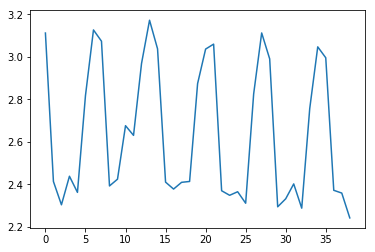

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.483206   
air_0164b9927d20bcc3_2017-04-23              1.783389   
air_0241aa3964b7f861_2017-04-23              2.430107   
air_0328696196e46f18_2017-04-23              2.071323   
air_034a3d5b40d5b1b1_2017-04-23              3.420664   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23  10.979612  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   4.949985  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.360096  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.935312  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.589708

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3001_ridge_run_0.csv.gz",compression='gzip')

In [132]:
df=pd.DataFrame({'y':validpred[0],"pred": validpred[2],'day': validpred[1][:,1]}).sort_values('day')
df['wd']=(df['day']-2)%7+1
df['e2']=(df['y']-df['pred'])**2
df.groupby('wd').mean()
df[df['e2']<0.4].mean()['e2'], \
(df['e2']<0.4).mean()

(0.08495869879625785, 0.98683207077126445)

In [133]:
df=pd.DataFrame({'y':trainpred[0],"pred": trainpred[2],'day': trainpred[1][:,1],'store': trainpred[1][:,0]}).sort_values('day')
df['wd']=(df['day']-2)%7+1
df['e2']=(df['y']-df['pred'])**2
df.groupby('wd').mean()
df[df['e2']<0.4].mean()['e2'], \
(df['e2']<0.4).mean()

(0.087585627266107177, 0.98539162554119109)

In [127]:
bads=pickle.load(open('bad_instance.pkl'))
len(bads)

0

In [128]:
bads=bads.union(set([tuple(u) for u in df.loc[df['e2']>0.4][['store','day']].values]))

In [129]:
pickle.dump(bads, open('bad_instance.pkl','wb'))

In [130]:
len(bads)

46787

In [88]:
baddf=pd.DataFrame(list(bads),columns=['store','day'])

In [99]:
baddf['wd']=(baddf['day']-2)%7

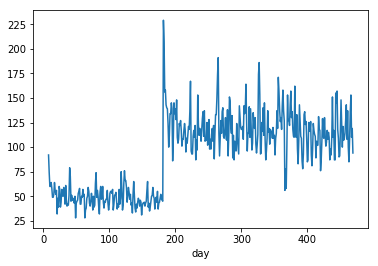

In [134]:
baddf.groupby('day').count()['wd'].plot()

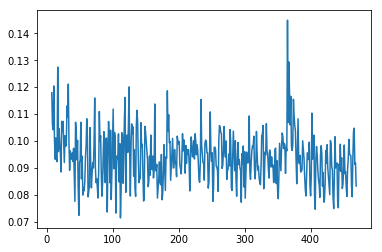

In [137]:
plt.plot(df.groupby('day').mean()['e2'])

In [170]:
a=df.groupby('day').mean()['e2']#.median()
a.iloc[np.where(a>0.4)].index

Int64Index([ 10,  41,  79,  80, 115, 123, 125, 129, 199, 223, 234, 265, 283,
            307, 327, 363, 364, 365, 366, 367, 368, 374, 444],
           dtype='int64', name=u'day')

In [171]:
df[df['e2']<0.4].mean()

day      283.274348
pred       2.853145
store    415.452078
y          2.895528
wd         4.230524
e2         0.091358
dtype: float64